**Version 11-12 Update**

- Upgrade TF `2.6` from `2.4`.
- Adjust corresponding issues due to package upgrade.
- Fix minor bugs and gramatical spelling.

**Version 9-10 Update**
 
- Added`TF` Augmentation for **3D** samples. 
- Added `Keras` Augmentation for **3D** samples. 
- Added `Volumentations` Augmentation for **3D** samples, which is based on **Albumentation**. Thanks to [ZFTurbo](https://github.com/ZFTurbo/volumentations).
- Add **Gradient Accumulation** technique in **3D** model training. More description are added to the relevant section on this notebook.

**Note**: For **3D** modeling, instead of `(h, w, depth * channel, 1)`, now we will be following `(h, w, depth, channel)`. For example: previously we have input shape as `(224, 224, 5*4, 1)` but now we've `(224, 224, 5, 4)`. Here, `4` is the number of modality in this dataset and `5` is the number of samples from each modality. 

Please, whom you've already forked the notebook, see the update from version **9**  as it contains some major changes. Also, in the data loader, we've added some basic functionalities to tackle the **full black image** and **less number of slices** regarding issue. Also, from version **9**, we will not update on `2D` modeling training approach; please feel free to check version 8 or lower for that if needed. 

**This code is full of commentry, please go through each line of this code example to understand correctly. Further update will be added to this repo: [innat/BrainTumorClassification](https://github.com/innat/BraTS-MGMT-Classification). If it becoems helpful for your projects and research, we would appreciate the [citation](https://github.com/innat/BraTS-MGMT-Classification/blob/main/CITATION.cff).**


---

**Version 8 Update**

- Update `tf.data` pipeline in a clean modular way, would be easy to tweak
- Add random data augmentation on each input modality (slices) using `tf.image.random_*` module 
- Add random `cutout` augmentation. 
- Add `3D` pre-trained modeling setup: `efficientnet-3d` and others. 
- Add `2D` modeling setup either: `efficientnet-2d` and others.
- Basic training of `3D` and `2D` modeling with shape of (`312, 312, 4, 1`) and (`312, 312, 4`) respectively. 

**Note**: The pre-trained weights of `3D` model is taken from [ZFTurbo/efficientnet_3D](https://github.com/ZFTurbo/efficientnet_3D) and [ZFTurbo/classification_models_3D](https://github.com/ZFTurbo/classification_models_3D). The weight files are uploaded and can be found from here ([efnet-3d](https://www.kaggle.com/ipythonx/keras-3d-efficientnet-imagenet-weights-b0b7)) and here ([classification-3d](https://www.kaggle.com/ipythonx/pretrained-3d-model-weights-keras)) respectively. 


**Version 3 Update**

- Wrap up `keras` sequence generator to `tf.data` API 
- Add data augmentation by using `keras` preprocessing layers 
- Subclass the model for tweaking gradient before update and reg loss 
- Train the model (`InceptionResNet3D`) with shape of (`256, 256, 20, 1`)


**Note**: As there are many empty image (`img.mean() == 0`) among four modalities, we found that, the training progress is bit unstable. We need to find out a better and efficient technique for `n` depth 3D model training. Also, we've seen that, among four series or modalities, training with only `T2w` was compratively better. 

---

## RSNA-MICCAI Brain Tumor Radiogenomic Classification

In this baseline example, we will be building a 3D convolutional neural network to predict the status of a genetic biomaker important for brain cancer treatment in the **mpMRI** scans that includes the following four types of images for single study or patient. 

```
- Fluid Attenuated Inversion Recovery (FLAIR)
- T1-weighted pre-contrast (T1w)
- T1-weighted post-contrast (T1Gd)
- T2-weighted (T2)
```

In the training data, each study (or each patient id e.g `00000`) belongs to a single label (`train_labels.csv`). Each of this study has further 4 series (`FLAIR`, `T1w`, `T1Gd`, `T2`), and each series has multiple images, in a DICOM format. The file structure is something looks like as follows:

```
Training/Validation/Testing
│
└─── 00000
│   │
│   └─── FLAIR
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T1w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T1wCE
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ ...
│   └─── T2w
│   │   │ Image-1.dcm
│   │   │ Image-2.dcm
│   │   │ .....
└─── 00001
│   │ ...
└─── 00002
│   │ ...
```

## TF.Keras Code

In [1]:
!pip install Keras-Applications==1.0.8 -q
!pip install ../input/keras-3d-model-and-3d-augmentation/efficientnet_3D-1.0.1-py3-none-any.whl -q
!pip install ../input/keras-3d-model-and-3d-augmentation/classification_models_3D-1.0.2-py3-none-any.whl -q
!pip install ../input/keras-3d-model-and-3d-augmentation/volumentations_3D-1.0.3-py3-none-any.whl -q

In [2]:
# general 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os, glob, random, cv2, glob, pydicom, warnings
from sklearn.model_selection import StratifiedKFold

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# ML pack
import tensorflow as tf; print(tf.__version__)
from tensorflow import keras

# If memory growth is enabled for a PhysicalDevice, the runtime - 
# initialization will not allocate all memory on the device.
physical_devices = tf.config.list_physical_devices('GPU')
try: 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    assert tf.config.experimental.get_memory_growth(physical_devices[0])
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass 

# Params 
AUTO = tf.data.AUTOTUNE

# For reproducible results    
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 

2.6.2


In [3]:
# Seed all
global_seed = 101 
seed_all(global_seed)

# Training Fold
total_fold = 5
fold = 0  

# After notebook version 8, modeling_in = '2D' is not supported. 
modeling_in = '3D' # Support:'2D' or '3D' modeling,  

# Augmentation library that can be used for 3D model training.
# We can use `keras` preprocessing image augmentation library,
# Or, we can use pure 'tf' image operations for augmentation, 
# Or, we can use 'volumentations' 3rd party library build on albumentation. 
aug_lib = 'keras'  # Support, arg: 'tf', 'keras', 'volumentations'

# In this competition, we have four modalities for each study
# If you want to train slngle modality training, you need to change few code 
# in the data loader. 
input_modality = ["FLAIR", "T1w", "T1wCE", "T2w"] 

# Sample input shape: 
# (batch_size, input_height, input_width, input_depth, input_channel) 
batch_size    = 1   # Number of the batch size
accum_step    = 3   # Gradient accumulation steps
input_height  = 120
input_width   = 120
input_channel = len(input_modality)  # Total number of channel, e.g. 4 
input_depth   = 30 # Total number of slices from each modality, e.g. 30 

In [4]:
root = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/'

df = pd.read_csv(f'{root}train_labels.csv') 
train_sample_path = f'{root}train'

print(df.shape)
print(df.MGMT_value.value_counts())

print('\nno. of the image {} and no. of the unique id {}'.\
      format(len(os.listdir(train_sample_path)), df.BraTS21ID.nunique()))

print('\ntop 5:')
df.head()

(585, 2)
1    307
0    278
Name: MGMT_value, dtype: int64

no. of the image 585 and no. of the unique id 585

top 5:


BraTS21ID  MGMT_value
0          0           1
1          2           1
2          3           0
3          5           1
4          6           1

# Data Loader

**Note: Notebook V.9+**: Almost same, except input shape now would be (`None, height, weight, 5, 4`). More details are added at the beginning of the notebook.

**Note: Notebook V.8**: For each study, we will pick **5** middle dicom or image samples at cetain interval from each of the four series (`FLAIR`, `T1w`, `T1Gd`, `T2`) for our 3D model input, e.g `input_shape: (None, height, weights, 5*4, 1)`. So, for picking 5 samples from each series, the depth would be `4 * 5` or `20` for each patient id or study id. However, we probabely need to find some better technique to pick samples from each of these four series though. For now, we're doing kinda random stuff. For example: check the following illustration; for the 3D model the input size would be : `height, width, 12, 1`. Also, as we already notice, there're too much black pixel, we will try to address that too. 


![quick png](https://user-images.githubusercontent.com/17668390/126070190-4a2d8aed-9dd8-4bee-aa15-f95429553a9c.png)

**Keras Sequence to TensorFlow tf.Data API**

It's known that, `tf.data` is more efficient when it comes to data pipelines compare to others, e.g. `keras` sequences data generator. Here we will try to wrap up an **existing `keras` sequence generator** to `tf.data` API using [tf.data.Dataset.from_generator function](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). 

In [5]:
skf = StratifiedKFold(n_splits=total_fold, shuffle=True, random_state=global_seed)

for index, (train_index, val_index) in enumerate(skf.split(X=df.index, 
                                                           y=df.MGMT_value)):
    df.loc[val_index, 'fold'] = index
    
print('Ground Truth Distribution Fold-Wise..')
print(df.groupby(['fold', df.MGMT_value]).size())

Ground Truth Distribution Fold-Wise..
fold  MGMT_value
0.0   0             55
      1             62
1.0   0             55
      1             62
2.0   0             56
      1             61
3.0   0             56
      1             61
4.0   0             56
      1             61
dtype: int64


In [6]:
# data loader 
class BrainTumorGenerator(keras.utils.Sequence):
    def __init__(self, dicom_path, data, is_train=True):
        self.is_train = is_train # to control training/validation/inference part 
        self.data = data
        self.dicom_path = dicom_path
        self.label = self.data['MGMT_value']
  
    def __len__(self):
        return len(self.data['BraTS21ID'])
    
    def __getitem__(self, index):
        patient_ids = f"{self.dicom_path}/{str(self.data['BraTS21ID'][index]).zfill(5)}/"
   
        # For 2D modeling 
        # NOTE: For 2D model training, see notebook version 8 or less. 
        channel = []
    
        # for 3D modeling 
        flair = []
        t1w   = []
        t1wce = []
        t2w   = [] 
        
        # Iterating over each modality
        for m, t in enumerate(input_modality):
            t_paths = sorted(
                glob.glob(os.path.join(patient_ids, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            
            # Pick input_depth times slices -
            # - from middle range possible 
            strt_idx = (len(t_paths) // 2) - (input_depth // 2)
            end_idx = (len(t_paths) // 2) + (input_depth // 2)
            # slicing extracting elements with 1 intervals 
            picked_slices = t_paths[strt_idx:end_idx:1]
            
            # Iterating over the picked slices and do some basic processing, 
            # such as removing black borders
            # and lastly, bind them all in the end.
            for i in picked_slices:
                # Reading pixel file from dicom file 
                image = self.read_dicom_xray(i)
                
                # It's possible that among picked_slices, there can be some black image, 
                # which is not wanted, so we iterate back to dicom file to get - 
                # - any non-black image otherwise move on with black image 
                j = 0
                while True:
                    # if it's a black image, try to pick any random slice of non-black  
                    # otherwise move on with black image. 
                    if image.mean() == 0:
                        # do something 
                        image = self.read_dicom_xray(random.choice(t_paths)) 
                        j += 1
                        if j == 100:
                            break
                    else:
                        break
                        
                # Now, we remove black areas; remove black borders from brain image 
                rows = np.where(np.max(image, 0) > 0)[0]
                cols = np.where(np.max(image, 1) > 0)[0]
                if rows.size:
                    image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
                else:
                    image = image[:1, :1]
           
                # In 3D modeling, we now add frames / slices of individual modalities 
                if modeling_in == '3D':
                    if m == 0:
                        # Adding flair 
                        flair.append(cv2.resize(image, (input_height, input_width)))
                    elif m == 1:
                        # Adding t1w
                        t1w.append(cv2.resize(image, (input_height, input_width)))
                    elif m == 2:
                        # Adding t1wce
                        t1wce.append(cv2.resize(image, (input_height, input_width)))
                    elif m == 3:
                        # Adding t2w
                        t2w.append(cv2.resize(image, (input_height, input_width)))
                elif modeling_in == '2D':
                    # Adding all frames at a time 
                    channel.append(cv2.resize(image, (input_height, input_width)))
                    

        if modeling_in == '3D':
            # [ATTENTION!!!]
            # input_shape: (None, h, w, depth, channel)
            # It's possible that with current data loader set up, 
            # All modalities MAY NOT HAVE SAME number of slices.
            # In that case, we adopt some workaround.
            # Right now, we re-append the existing slice with small color variation.
            # Just to avoid this issue.
            
            # for flair 
            while True:
                if len(flair) < input_depth and flair:
                    flair.append(cv2.convertScaleAbs(random.choice(flair), alpha=1.2, beta=0))
                else:
                    break
            
            # for t1w
            while True:
                if len(t1w) < input_depth and t1w:
                    t1w.append(cv2.convertScaleAbs(random.choice(t1w), alpha=1.1, beta=0))
                else:
                    break

            # for t1wce
            while True:
                if len(t1wce) < input_depth and t1wce:
                    t1wce.append(cv2.convertScaleAbs(random.choice(t1wce), alpha=1.2, beta=0))
                else:
                    break

            # for t2w
            while True:
                if len(t2w) < input_depth and t2w:
                    t2w.append(cv2.convertScaleAbs(random.choice(t2w), alpha=1.1, beta=0))
                else:
                    break
            
            return np.array((flair, t1w, t1wce, t2w),
                            dtype="object").T, self.label.iloc[index,]
            
    
        elif modeling_in == '2D':
            # (None, h, w, channel == depth)
            return np.array(channel).T, self.label.iloc[index,]
        
    # Function to read dicom file 
    def read_dicom_xray(self, path):
        data = pydicom.read_file(path).pixel_array
        if data.mean() == 0:
            # If all black, return data and find non-black if possible.
            return data 
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)
        return data

In [7]:
def fold_generator(fold):
    train_labels = df[df.fold != fold].reset_index(drop=True)
    val_labels   = df[df.fold == fold].reset_index(drop=True)
    return (
        BrainTumorGenerator(train_sample_path, train_labels),
        BrainTumorGenerator(train_sample_path, val_labels)
    )

# Get fold set
train_gen, val_gen = fold_generator(fold)

## `Keras` Pipelines to `tf.data` Pipelines

In [8]:
if modeling_in == '2D':
    train_data = tf.data.Dataset.from_generator(
        lambda: map(tuple, train_gen),
        (tf.float32, tf.float32),
        (
            tf.TensorShape([input_height, input_width, input_depth*input_channel]),
            tf.TensorShape([]),
        ),
    )

    val_data = tf.data.Dataset.from_generator(
        lambda: map(tuple, val_gen),
        (tf.float32, tf.float32),
        (
            tf.TensorShape([input_height, input_width, input_depth*input_channel]),
            tf.TensorShape([]),
        ),
    )
else:
    train_data = tf.data.Dataset.from_generator(
        lambda: map(tuple, train_gen),
        (tf.float32, tf.float32),
        (
            tf.TensorShape([input_height, input_width, input_depth, input_channel]),
            tf.TensorShape([]),
        ),
    )

    val_data = tf.data.Dataset.from_generator(
        lambda: map(tuple, val_gen),
        (tf.float32, tf.float32),
        (
            tf.TensorShape([input_height, input_width, input_depth, input_channel]),
            tf.TensorShape([]),
        ),
    )

# 3D Augmentation

In order to do data augmentation on 3D samples, we will have option to choose `keras` image preprocessing layers, `tf` image deterministic modules and `volumentations` which is based on well-known albumentation package. Note that, same augmentation of all slices from each modality needs to be ensured.

- In `keras`, we've some built-in [Image augmentation layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/). We can use it in data loading time or we can integrate them inside the model definition to leverage GPU power. For now, we'll be using them on data loading section. We will also implement and use some custom layers for image augmentation. Note that, we need to ensure that, same augmentation must be applied to each slices of a modality, otherwise it'd be probabely meaningless to use them. FYI, `keras` has a convinient function called [TimeDistributed](https://keras.io/api/layers/recurrent_layers/time_distributed/) which can be applied in such case. 


- In `tf`, we'll be using [`tf.image.stateless_*`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness) modules for deterministic results. So that, we can apply same augmentation on all slices of a modality. 

- Lastly, in `volumentations`, originally developed by [hawkey](https://github.com/ashawkey/volumentations) and greatly improved by [ZFTurbo](https://github.com/ZFTurbo/volumentations). Please, appreciate their open-source code if it helps. The same augmentation is handle by itself; less pain. 

## Keras 3D Augmentation


From API, we've `RandomFlip`, `RandomRotation`, `RandomCrop` etc layers. Apart from the buil-in layer, we will be building our own image processing layer and use them for image augmentation. For example: `RandomInvert`, `RandomEqualize` and `RandomCutout`.

In [9]:
import tensorflow_addons as tfa
from tensorflow.keras import layers

# Custom Layer 1 
class RandomInvert(layers.Layer):
    def __init__(self, prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.prob = prob
        
    def call(self, inputs, training=True):
        tf.random.set_seed(global_seed)
        if tf.random.uniform([]) < self.prob:
            return tf.cast(255.0 - inputs, dtype=tf.float32)
        else: 
            return tf.cast(inputs, dtype=tf.float32)
        
    def get_config(self):
        config = {
            'prob': self.prob,
        }
        base_config = super(RandomInvert, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
# Custom Layer 2 
class RandomEqualize(layers.Layer):
    def __init__(self, prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.prob = prob
        
    def call(self, inputs, training=True):
        tf.random.set_seed(global_seed)
        if tf.random.uniform([]) < self.prob:
            return tf.cast(tfa.image.equalize(inputs), dtype=tf.float32)
        else: 
            return tf.cast(inputs, dtype=tf.float32)
        
    def get_config(self):
        config = {
            'prob': self.prob,
        }
        base_config = super(RandomEqualize, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        return input_shape
        
# Custom Layer 3
class RandomCutout(layers.Layer):
    def __init__(self, prob=0.5, mask_size=(20, 20), replace=0, **kwargs):
        super().__init__(**kwargs)
        self.prob = prob 
        self.replace = replace
        self.mask_size = mask_size
        
    def call(self, inputs, training=True):
        tf.random.set_seed(global_seed)
        if tf.random.uniform([]) < self.prob:
            inputs = tfa.image.random_cutout(inputs, 
                                             mask_size=self.mask_size, 
                                             constant_values=self.replace)  
            return tf.cast(inputs, dtype=tf.float32)
        else: 
            return tf.cast(inputs, dtype=tf.float32)
        
    def get_config(self):
        config = {
            'prob': self.prob,
            'replace': self.replace,
            'mask_size': self.mask_size
        }
        base_config = super(RandomCutout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [10]:
set_seed = None
rand_flip = layers.RandomFlip("horizontal_and_vertical", seed=set_seed)
rand_tran = layers.RandomTranslation(height_factor=0.1, width_factor=0.2, seed=set_seed)
rand_rote = layers.RandomRotation(factor=0.01, seed=set_seed)
rand_cntr = layers.RandomContrast(factor=0.6, seed=set_seed)
rand_crop = layers.RandomCrop(int(input_height*0.97), int(input_width*0.97), seed=set_seed)
rand_eqlz = RandomEqualize()

def keras_augment(image, label):
    all_modality = tf.reshape(image, [-1, input_height, input_width, input_depth*input_channel])
    
    def apply_augment(x):
        x = rand_eqlz(x)
        x = rand_flip(x)
        x = rand_tran(x)
        x = rand_rote(x)
        x = rand_cntr(x)
        x = rand_crop(x)
        x = layers.Resizing(input_height, input_width)(x)
        return x 
    
    aug_images = apply_augment(all_modality)
    image = tf.reshape(aug_images, 
                       [-1, input_height, input_width, input_depth, input_channel])
    
    return image, label

In [11]:
if modeling_in == '2D':
    #  keras augmentation
    keras_augment = tf.keras.Sequential(
        [
            RandomFlip("horizontal", dtype=tf.float32),
            RandomRotation(factor=0.01, dtype=tf.float32),
            RandomTranslation(height_factor=0.0, width_factor=0.1, dtype=tf.float32),
            RandomZoom(height_factor=(-0.1, -0.2), width_factor=(-0.1, -0.2)),
            RandomInvert(prob=0.1),
            RandomCutout(prob=0.8, replace=0, 
                         mask_size=(int(input_height * 0.2),
                                    int(input_width * 0.2))),
            RandomEqualize(prob=0.5)
        ],
        name='keras_augment_layers'
    )

## TensorFlow 3D Augmentation

From `TF` API, we have very few built-in image processing functions for image augmentation. As we need deterministic results for each slice of a modality, we will be using `tf.image.stateless_*` modules and some few others with conditions. Some of the augmentaions are 

```
- tf.image.stateless_*
- tf.image.adjust_gama
- tfa.image.random_cutout
- Random gaussian noise
```

In [12]:
def tf_image_augmentation(image):  
    # splitted based on modalites. we have 4 type of modalities. Input shape (h, w, depth, channel==4)
    if modeling_in == '3D':
        # input shape: image.shape -> (h, w, input_depth, input_channel)
        # in such condition, we split based on the number of channel, which is 4 here. 
        # after that the variable will contains 4 splitted tensor 
        # each of which is in a shape of (h, w, input_depth, 1)
        splitted_modalities = tf.split(tf.cast(image, tf.float32), input_channel, axis=-1) 
    elif modeling_in == '2D':
        # input shape: image.shape -> (h, w, input_depth * input_channel)
        # in such condition, we split based on the number of channel, which is 4 here.
        # after that the variable will contains 4 splitted tensor 
        # each of which is in a shape of (h, w, input_depth)
        splitted_modalities = tf.split(tf.cast(image, tf.float32), input_channel, axis=-1) 
    
    
    # augmented frames for 2d modeling 
    # for 2d modeling we use 1 container to gather all augmented samples from 4 modalites
    # however, same augmentation is ensured for each modality for one study
    augment_img = []
    
    # augmented frames for 3d modeling 
    # for 3d modeling we use 4 container to gather all augmented samples from 4 modalites
    # however, same augmentation is ensured for each modality for one study
    flair_augment_img = []
    t1w_augment_img   = []
    t1wce_augment_img = []
    t2w_augment_img   = []
    
    
    if modeling_in == '3D':
        # remove the last axis.
        # input: (h, w, input_depth, 1) : output: (h, w, input_depth)
        splitted_modalities = [tf.squeeze(i, axis=-1) for i in splitted_modalities] 
    
    # iterate over each modalities, e.g: flair, t1w, t1wce, t2w
    for j, modality in enumerate(splitted_modalities):
        # now splitting each frame from one modality 
        splitted_frames = tf.split(tf.cast(modality, tf.float32), modality.shape[-1], axis=-1)
        
        # iterate over each frame to conduct same augmentation on 
        # each frame 
        for i, img in enumerate(splitted_frames):
            # Given the same seed, they return the same results independent of 
            # how many times they are called.
            # It's very important to get deterministic augmentation results of each modality. 
            tf.random.set_seed(j)
            np.random.seed(j)
            
            # In tf.image.stateless_random_* , the seed is a Tensor of shape (2,) -
            # - whose values are any integers.
            img = tf.image.stateless_random_flip_left_right(img, seed = (j, 2))
            img = tf.image.stateless_random_flip_up_down(img, seed = (j, 2))
            img = tf.image.stateless_random_contrast(img, 0.4, 0.8, seed = (j, 2))
            img = tf.image.stateless_random_brightness(img, 0.3, seed = (j, 2))
            
            # For some operation, it requires channel == 3 
            img = tf.image.stateless_random_saturation(tf.image.grayscale_to_rgb(img), 
                                                       0.9, 1.8, seed = (j, 2))
            img = tf.image.stateless_random_hue(img, 0.4, seed = (j, 2))

            # For some operation we don't need channel == 3, just 1 is enough 
            img = tf.image.rgb_to_grayscale(img)
            img = tf.cast(
                tf.image.stateless_random_jpeg_quality(
                    tf.cast(img, tf.uint8), 
                    min_jpeg_quality=20, max_jpeg_quality=40, seed = (j, 2)
                ), tf.float32)

            # Ensuring same augmentation for each modalities 
            if tf.random.uniform((), seed=j) > 0.7:
                kimg = np.random.choice([1,2,3,4])
                kgma = np.random.choice([0.7, 0.9, 1.2])
                
                img = tf.image.rot90(img, k=kimg) # random rate to any of 90, 180, 270, 360 
                img = tf.image.adjust_gamma(img, gamma=kgma) # adjust the gamma 
                noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.2,
                                         dtype=tf.float32, seed=j) 
                img = img + noise # additive gaussian noise to image 

            # The mask_size should be divisible by 2. 
            if tf.random.uniform((), seed=j) > 0.6:
                img = tfa.image.random_cutout(tf.expand_dims(img, 0),
                                              mask_size=(int(input_height * 0.2),
                                                         int(input_width * 0.2)), 
                                              constant_values=0) 
                img = tf.squeeze(img, axis=0)
            
            # Clipping. We'll rescale later. 
            img = tf.clip_by_value(img, 0, 255)
            
            # Gathering all frames 
            if modeling_in == '3D':
                if j == 0: # 1st modality 
                    flair_augment_img.append(img)
                elif j == 1: # 2nd modality 
                    t1w_augment_img.append(img)
                elif j == 2: # 3rd modality 
                    t1wce_augment_img.append(img)
                elif j == 3:  # 4th modality 
                    t2w_augment_img.append(img)
            elif modeling_in == '2D':
                augment_img.append(img)
      
    
    if modeling_in == '3D':
        image = tf.transpose([flair_augment_img, t1w_augment_img, 
                              t1wce_augment_img, t2w_augment_img])
        image = tf.reshape(image, [input_height, input_width, input_depth, input_channel])
    elif modeling_in == '2D':
        image = tf.concat(augment_img, axis=-1)
        image = tf.reshape(image, [input_height, input_width, input_depth*input_channel])
    return image

## Volumentation 3D

Please, refer to this [official page](https://github.com/ZFTurbo/volumentations#volumentations-3d), for better description. Here, we will show you how to use them with `tf.data` API pipelines.

In [13]:
from functools import partial
from volumentations import *

def get_augmentation(patch_size):
    return Compose([
        Rotate((-5, 5), (0, 0), (0, 0), p=0.5),
        RandomCropFromBorders(crop_value=0.1, p=0.3),
        ElasticTransform((0, 0.15), interpolation=2, p=0.5),
        Resize(patch_size, interpolation=1, always_apply=True, p=1.0),
        Flip(0, p=0.5),
        Flip(1, p=0.5),
        RandomRotate90((0, 1), p=0.6),
        GaussianNoise(var_limit=(0, 5), p=0.5),
        RandomGamma(gamma_limit=(0.5, 1.5), p=0.7),
    ], p=1.0)

volume3D = get_augmentation((input_height, input_width, input_depth))

def volume3Dfn(image):    
    aug_data = volume3D(**{"image":image})
    return tf.cast(aug_data["image"], tf.float32)

def volumentations_aug(image, label):
    # Wraps a python function and uses it as a TensorFlow op.
    aug_img = tf.numpy_function(func=volume3Dfn, 
                                inp=[image], 
                                Tout=tf.float32)
    aug_img.set_shape((input_height, input_width, input_depth, input_channel))
    return aug_img, label

# `tf.Data` Generator (Master Class)

In [14]:
class TFDataGenerator:
    def __init__(self, 
                 data, 
                 modeling_in, 
                 shuffle, 
                 aug_lib,
                 batch_size, 
                 rescale):
        if modeling_in not in ['2D', '3D']:
            raise ValueError('modeling_in is not set either 2D or 3D')
        self.data        = data             # data files 
        self.modeling_in = modeling_in      # 2D or 3D 
        self.shuffle     = shuffle          # true for training 
        self.aug_lib     = aug_lib          # type of augmentation library 
        self.batch_size  = batch_size       # batch size number 
        self.rescale     = rescale          # normalize or not 
        
    # a convinient function to get 2D data set 
    def get_2D_data(self):
        self.data = self.data.shuffle(buffer_size = self.batch_size * 100) \
                                                        if self.shuffle \
                                                        else self.data
        
        if self.aug_lib == 'tf' and self.shuffle:
            # augmentaiton using tf.image.stateless_random* functions 
            # applicable for multiple channel (channel > 3 )
            # same augmentation would be applied to each modalites: flair, t1w, t1wce, t2w
            # check the tf_image_augmentation code for details 
            self.data = self.data.map(lambda x, y: (tf_image_augmentation(x), y),
                                      num_parallel_calls=AUTO).batch(self.batch_size,
                                                                     drop_remainder=self.shuffle)
        elif self.aug_lib == 'keras' and self.shuffle:
            # augmentaion using keras image preprocessing layers 
            # applicable for multiple channels (channel > 3)
            # [known issue]:  same augmentaion would be applied for all modalites 
            # check the tf_image_augmentation code for details  
            self.data = self.data.batch(self.batch_size, drop_remainder=self.shuffle) 
            self.data = self.data.map(lambda x, y: (keras_augment(x,training=True),
                                                    y), 
                                      num_parallel_calls=AUTO)
        elif not self.shuffle:
            # no shuffle generally assuming no augmentaion too, so not training 
            # for inference and evaluation 
            self.data = self.data.batch(self.batch_size, drop_remainder=self.shuffle) 
            
            
        # rescaling the data for faster convergence 
        if self.rescale:    
            self.data = self.data.map(lambda x, y: (layers.Rescaling(scale=1./255, offset=0.0)(x), y), 
                                      num_parallel_calls=AUTO)
            
        # prefetching the data 
        return self.data.prefetch(-1) 
            
    # a convinient function to get 3D data set 
    def get_3D_data(self):
        # augmentation on 3D data set
        # volumentation is based on albumentation, followed by tf and keras 
        if self.aug_lib == 'volumentations' and self.shuffle:
            self.data = self.data.map(partial(volumentations_aug), num_parallel_calls=AUTO)
            self.data = self.data.batch(batch_size, drop_remainder=self.shuffle)
        elif self.aug_lib == 'tf' and self.shuffle:
            self.data = self.data.map(lambda x, y: (tf_image_augmentation(x), y),num_parallel_calls=AUTO)
            self.data = self.data.batch(self.batch_size,drop_remainder=self.shuffle)
        elif self.aug_lib == 'keras' and self.shuffle:
            self.data = self.data.batch(self.batch_size, drop_remainder=self.shuffle) 
            self.data = self.data.map(lambda x, y: keras_augment(x, y), num_parallel_calls=AUTO)
        else:
            # true for evaluation and inference, no augmentation 
            self.data = self.data.batch(self.batch_size, drop_remainder=self.shuffle)
        
        # rescaling the data for faster convergence 
        if self.rescale:    
            self.data = self.data.map(lambda x, y: (layers.Rescaling(scale=1./255, offset=0.0)(x), y), 
                                      num_parallel_calls=AUTO)
            
        # prefetching the data 
        return self.data.prefetch(-1) 

Get Train Set with **TensorFlow Augmentation**; Let's visualize it.

In [15]:
tf_gen = TFDataGenerator(
    train_data,
    modeling_in = modeling_in, 
    shuffle     = True,     
    aug_lib     = 'tf',  
    batch_size  = batch_size,   
    rescale     = True
)  
                   
if modeling_in == '2D':
    train_generator = tf_gen.get_2D_data()
elif modeling_in == '3D':
    train_generator = tf_gen.get_3D_data()

(1, 120, 120, 30, 4) (1,) 0.8941177 1.0


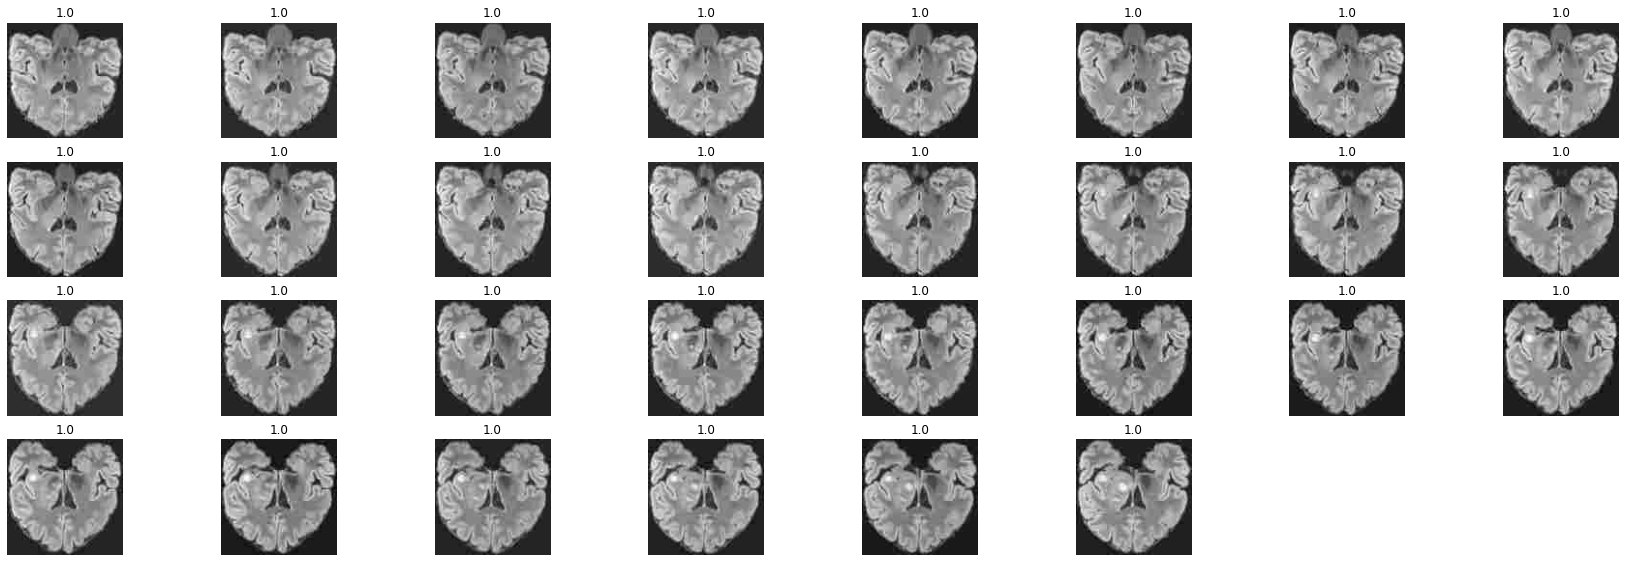

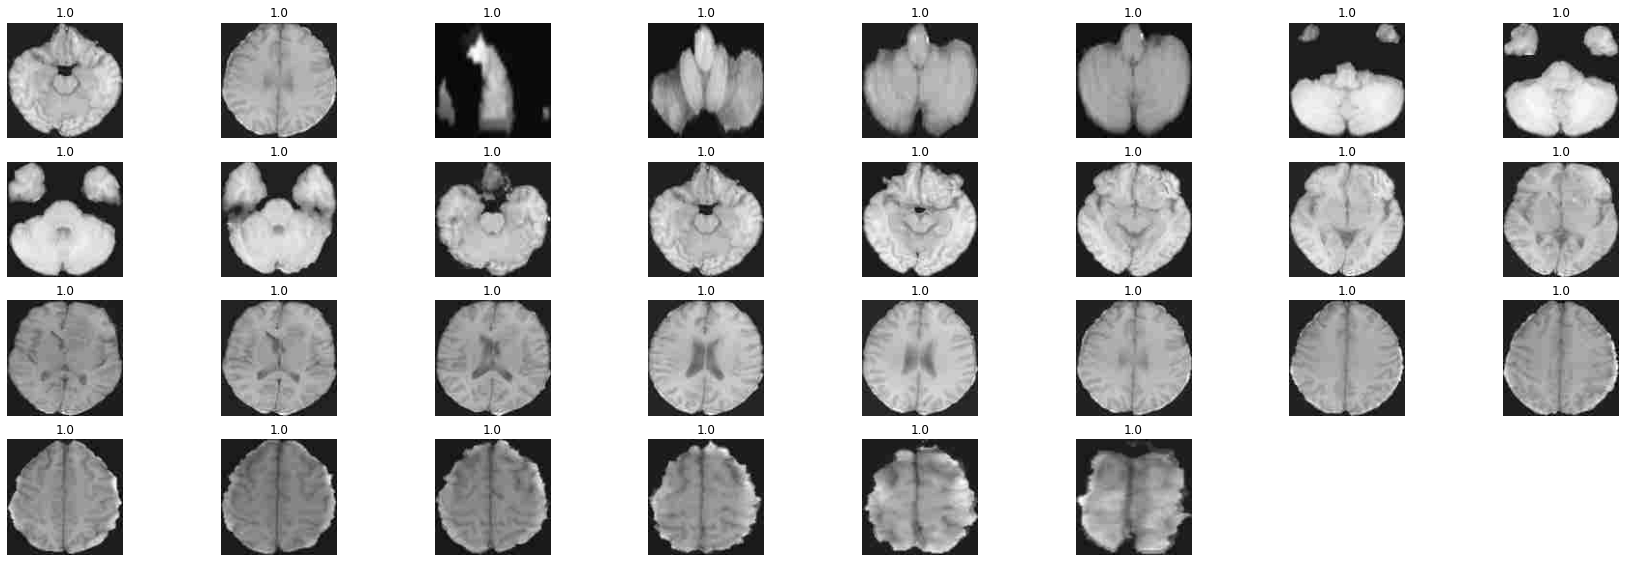

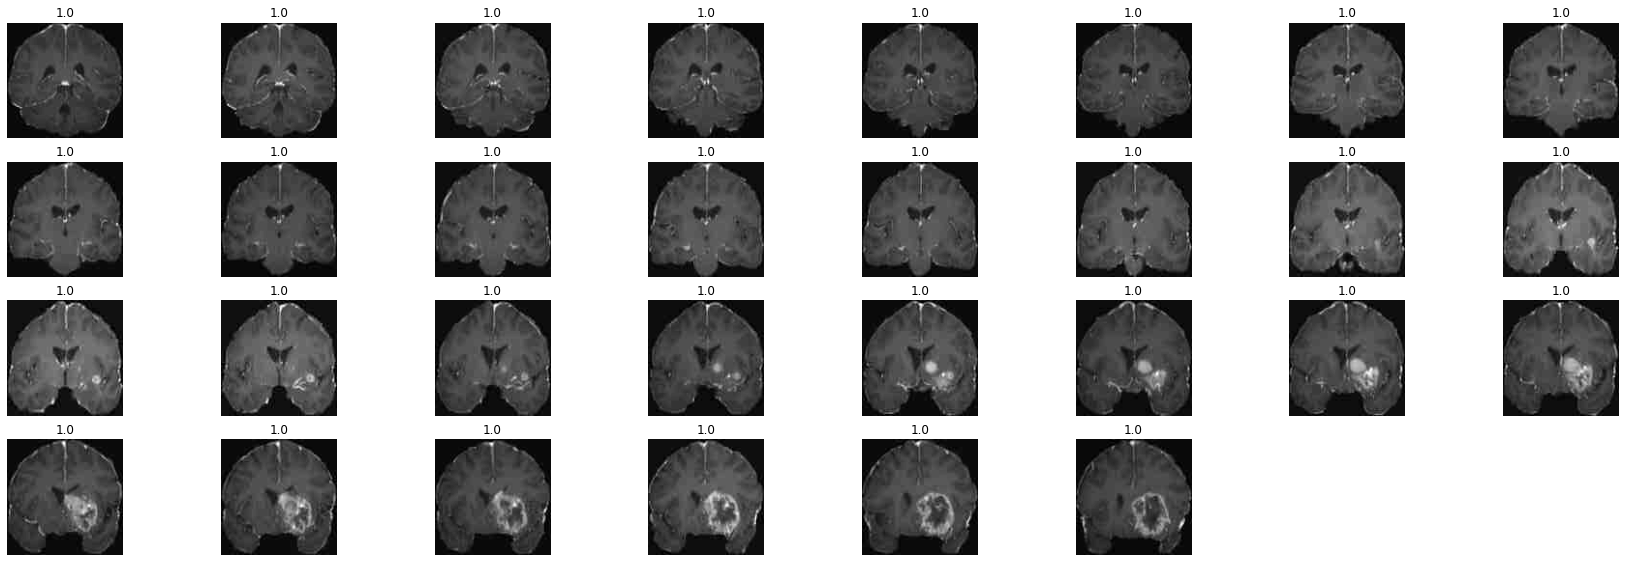

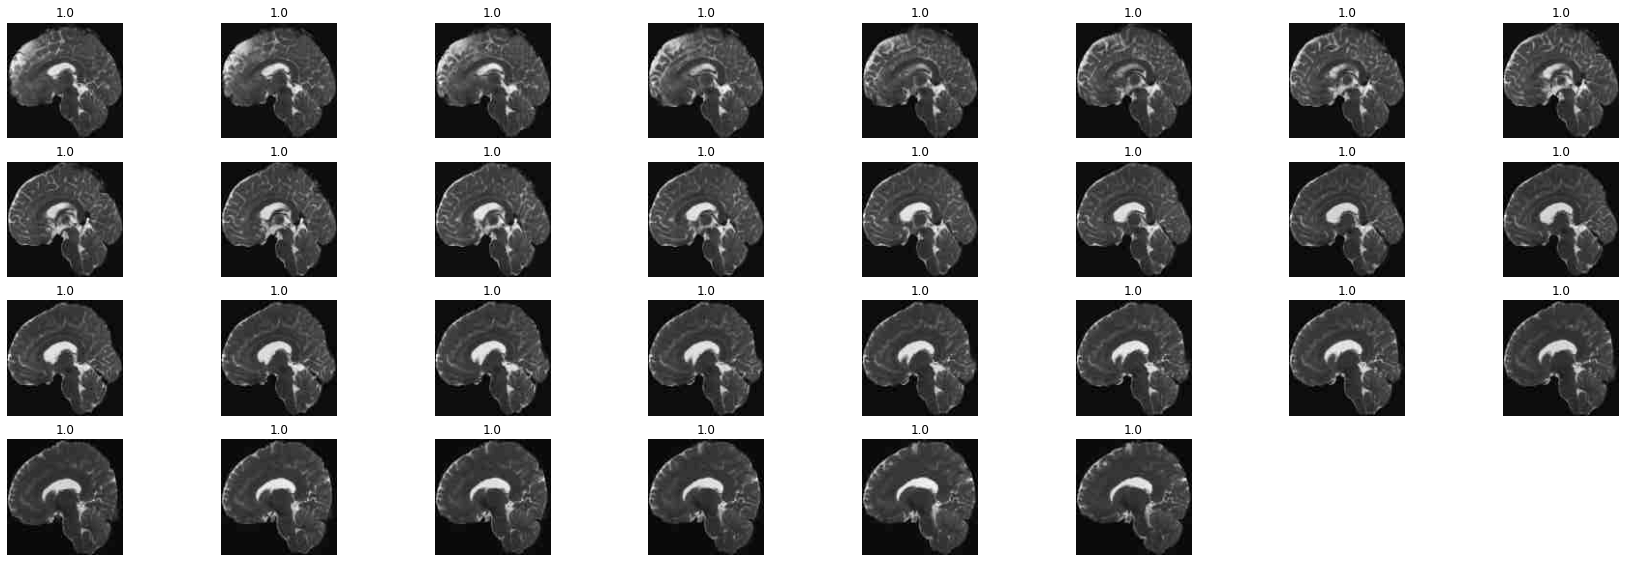

In [16]:
x, y = next(iter(train_generator))
print(x.shape, y.shape, x.numpy().max(), y.numpy().min())  

if modeling_in == '3D':
    for j in range(input_channel):
        plt.figure(figsize=(30, 20))
        for i in range(input_depth):
            plt.subplot(8, 8, i + 1)
            plt.imshow(x[0 ,:, :, i, j], cmap='gray')
            plt.axis("off")
            plt.title(y[0].numpy())
        plt.show()
elif modeling_in == '2D':
    plt.figure(figsize=(30, 20))
    for i in range(input_depth*input_channel):
        plt.subplot(5, 8, i + 1)
        plt.imshow(x[5 ,:, :, i], cmap='gray')
        plt.axis("off")
        plt.title(y[j].numpy())

Get Train Set with **Volumentations Augmentation**; Let's visualize it.

In [17]:
tf_gen = TFDataGenerator(
    train_data,
    modeling_in = modeling_in, 
    shuffle     = True,     
    aug_lib     = 'volumentations',
    batch_size  = batch_size,  
    rescale     = True
)   
                   
if modeling_in == '2D':
    train_generator = tf_gen.get_2D_data()
elif modeling_in == '3D':
    train_generator = tf_gen.get_3D_data()

(1, 120, 120, 30, 4) (1,) 1.0 1.0


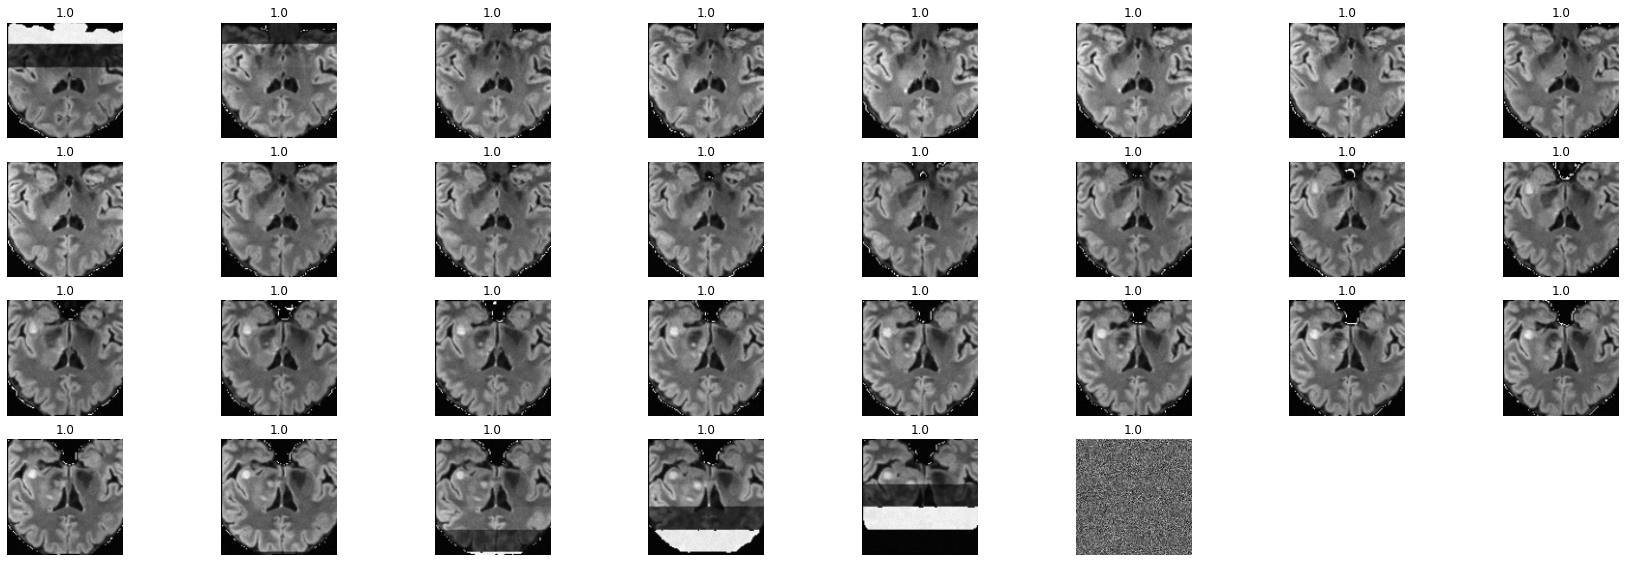

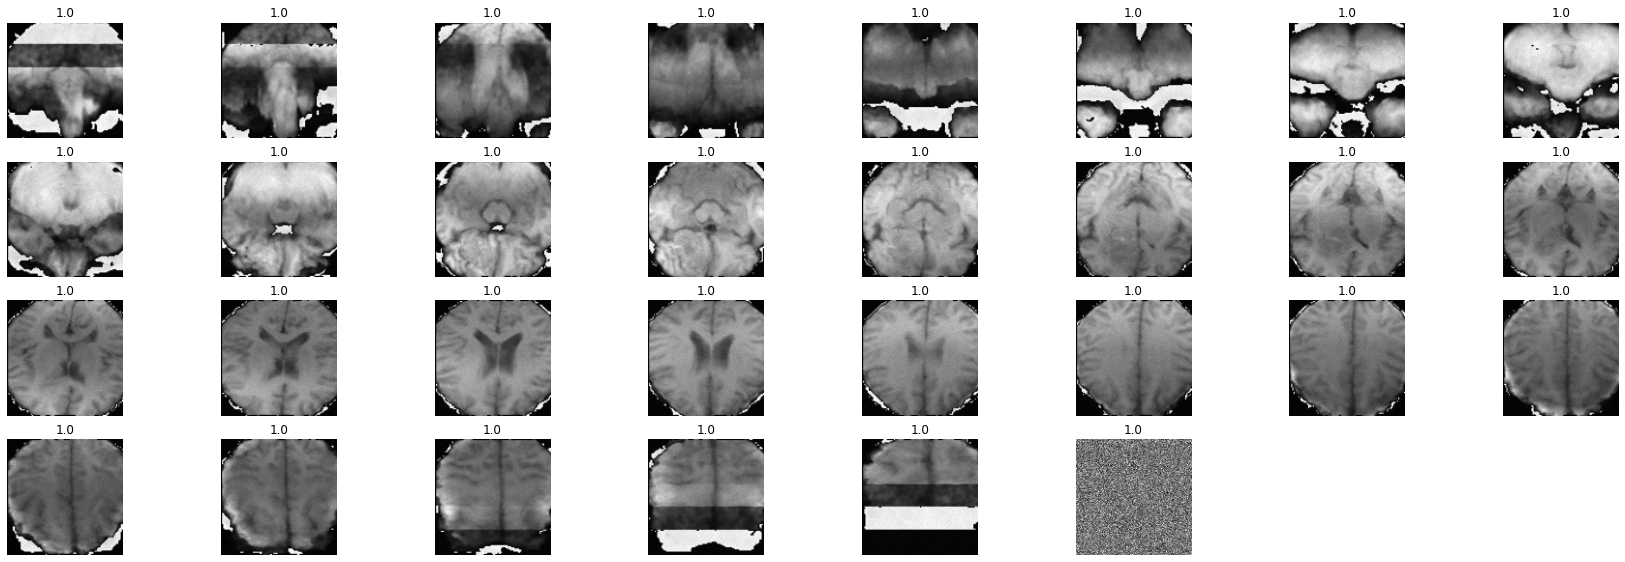

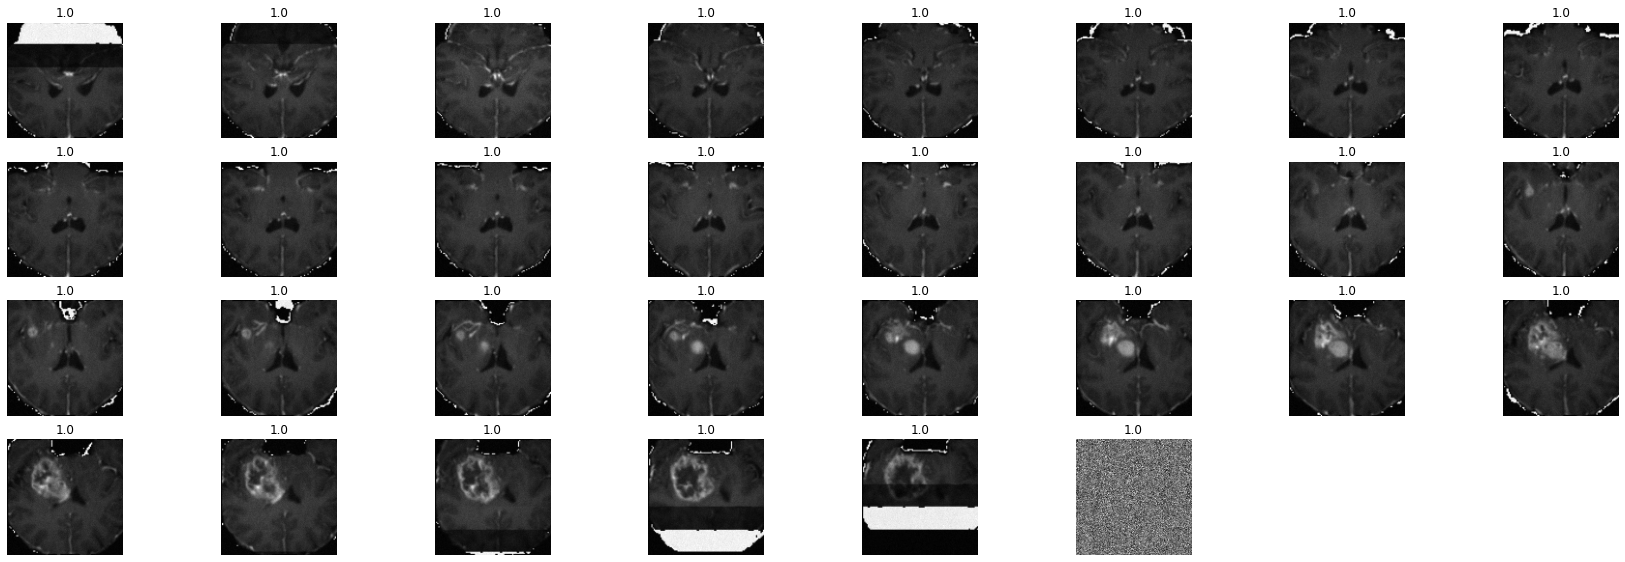

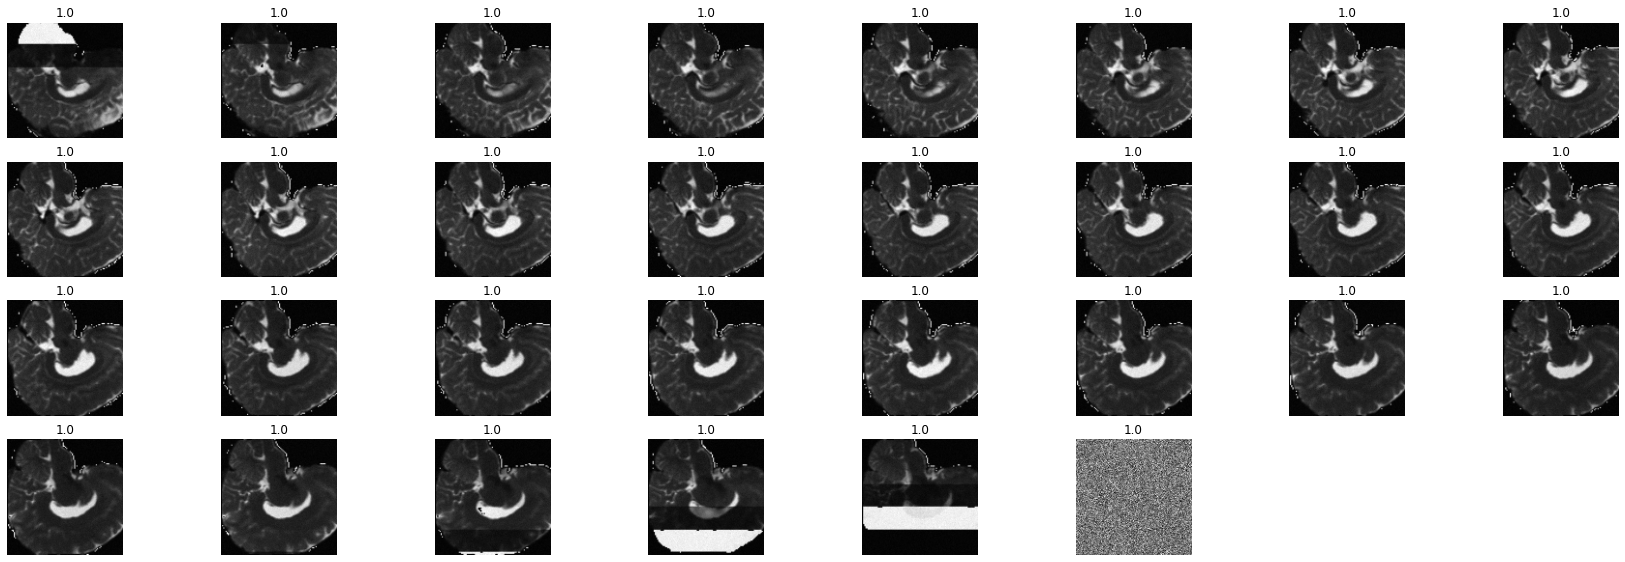

In [18]:
x, y = next(iter(train_generator))
print(x.shape, y.shape, x.numpy().max(), y.numpy().min())  

if modeling_in == '3D':
    for j in range(input_channel):
        plt.figure(figsize=(30, 20))
        for i in range(input_depth):
            plt.subplot(8, 8, i + 1)
            plt.imshow(x[0 ,:, :, i, j], cmap='gray')
            plt.axis("off")
            plt.title(y[0].numpy())
        plt.show()
elif modeling_in == '2D':
    plt.figure(figsize=(30, 20))
    for i in range(input_depth*input_channel):
        plt.subplot(5, 8, i + 1)
        plt.imshow(x[5 ,:, :, i], cmap='gray')
        plt.axis("off")
        plt.title(y[j].numpy())

Get Train Set with **Keras Augmentation**; Let's visualize it.

In [19]:
tf_gen = TFDataGenerator(
    train_data,
    modeling_in = modeling_in, 
    shuffle     = True,     
    aug_lib     = 'keras', 
    batch_size  = batch_size,   
    rescale     = True
)   
                   
if modeling_in == '2D':
    train_generator = tf_gen.get_2D_data()
elif modeling_in == '3D':
    train_generator = tf_gen.get_3D_data()

(1, 120, 120, 30, 4) (1,) 0.8978417 1.0


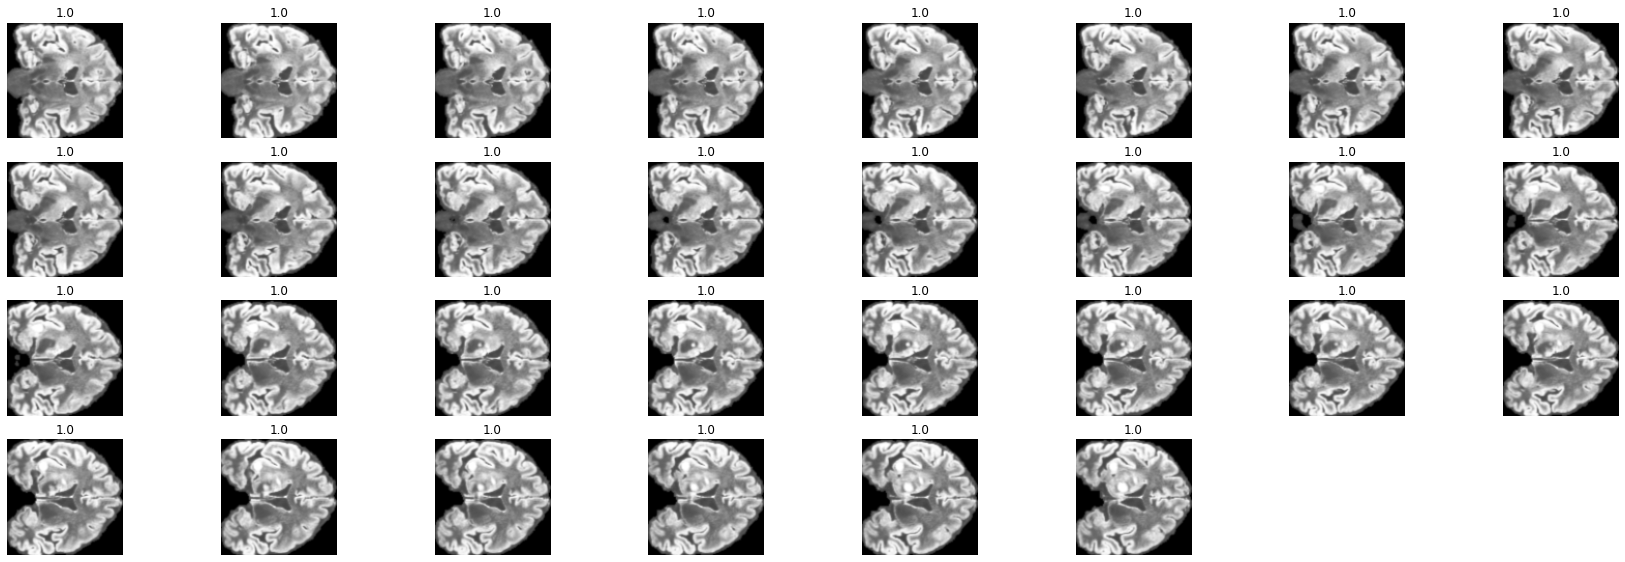

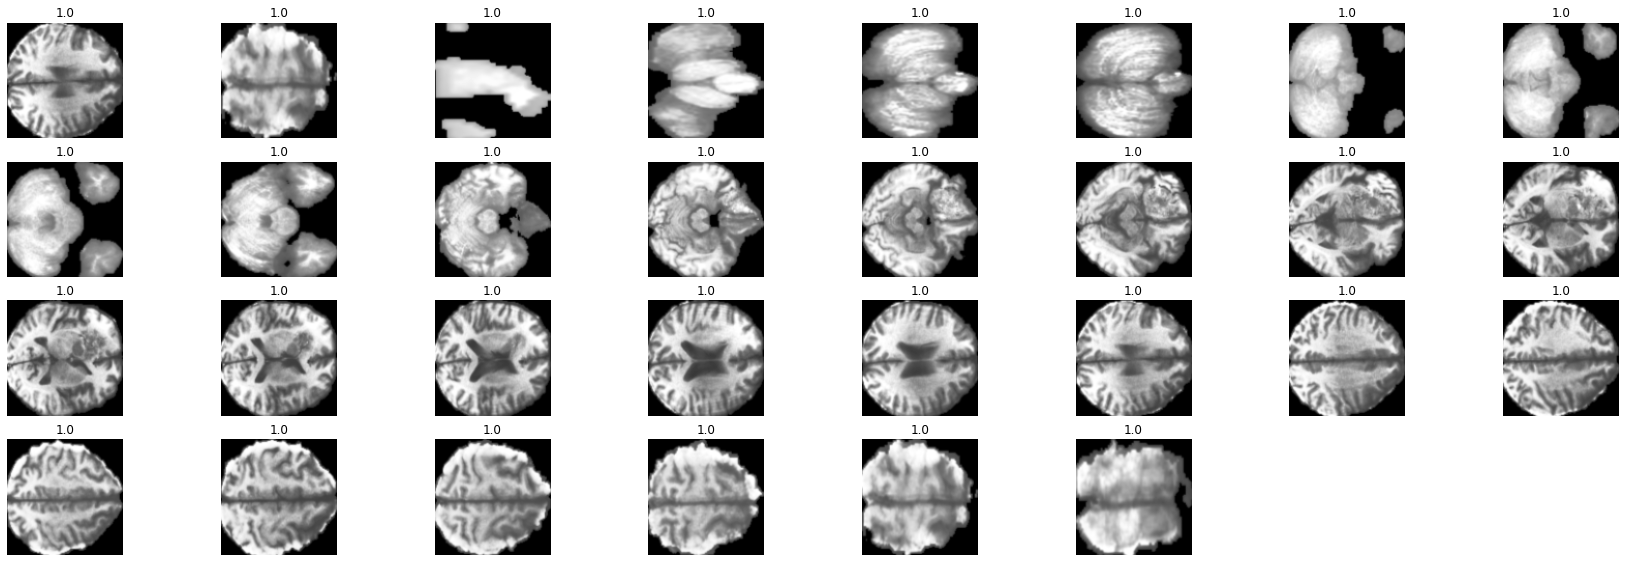

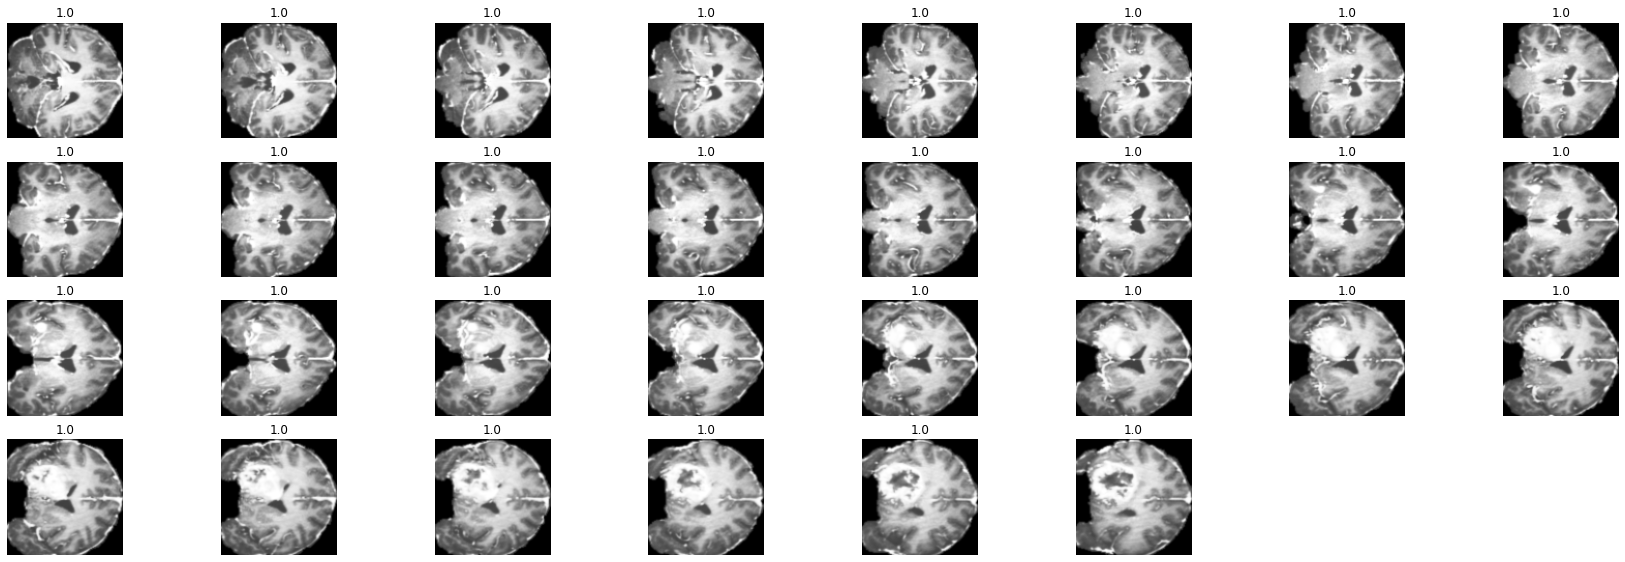

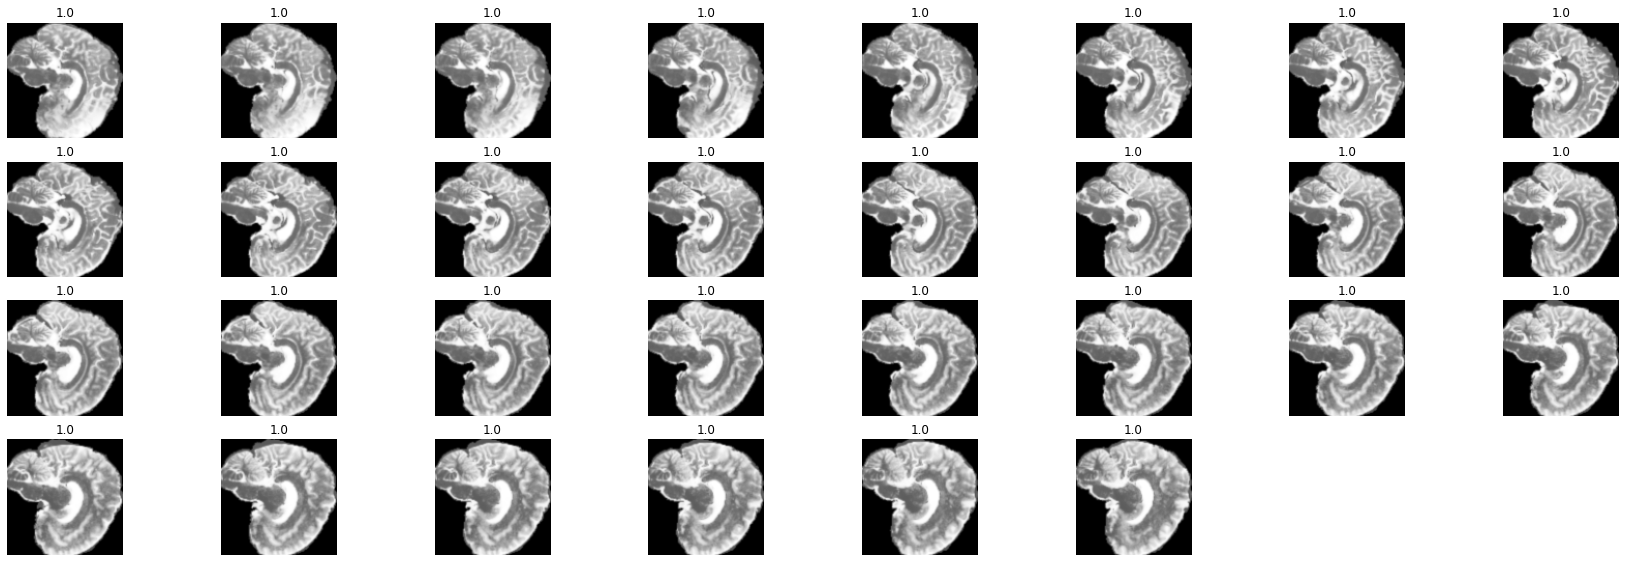

In [20]:
x, y = next(iter(train_generator))
print(x.shape, y.shape, x.numpy().max(), y.numpy().min())  

if modeling_in == '3D':
    for j in range(input_channel):
        plt.figure(figsize=(30, 20))
        for i in range(input_depth):
            plt.subplot(8, 8, i + 1)
            plt.imshow(x[0 ,:, :, i, j], cmap='gray')
            plt.axis("off")
            plt.title(y[0].numpy())
        plt.show()
elif modeling_in == '2D':
    plt.figure(figsize=(30, 20))
    for i in range(input_depth*input_channel):
        plt.subplot(5, 8, i + 1)
        plt.imshow(x[5 ,:, :, i], cmap='gray')
        plt.axis("off")
        plt.title(y[j].numpy())

**Get Validation Set**

In [21]:
tf_gen = TFDataGenerator(
    val_data,
    modeling_in = modeling_in,  
    shuffle     = False,     
    aug_lib     = None,    
    batch_size  = batch_size,   
    rescale     = True          
) 

if modeling_in == '2D':
    valid_generator = tf_gen.get_2D_data()
elif modeling_in == '3D':
    valid_generator = tf_gen.get_3D_data()

(1, 120, 120, 30, 4) (1,) 0.9960785 1.0


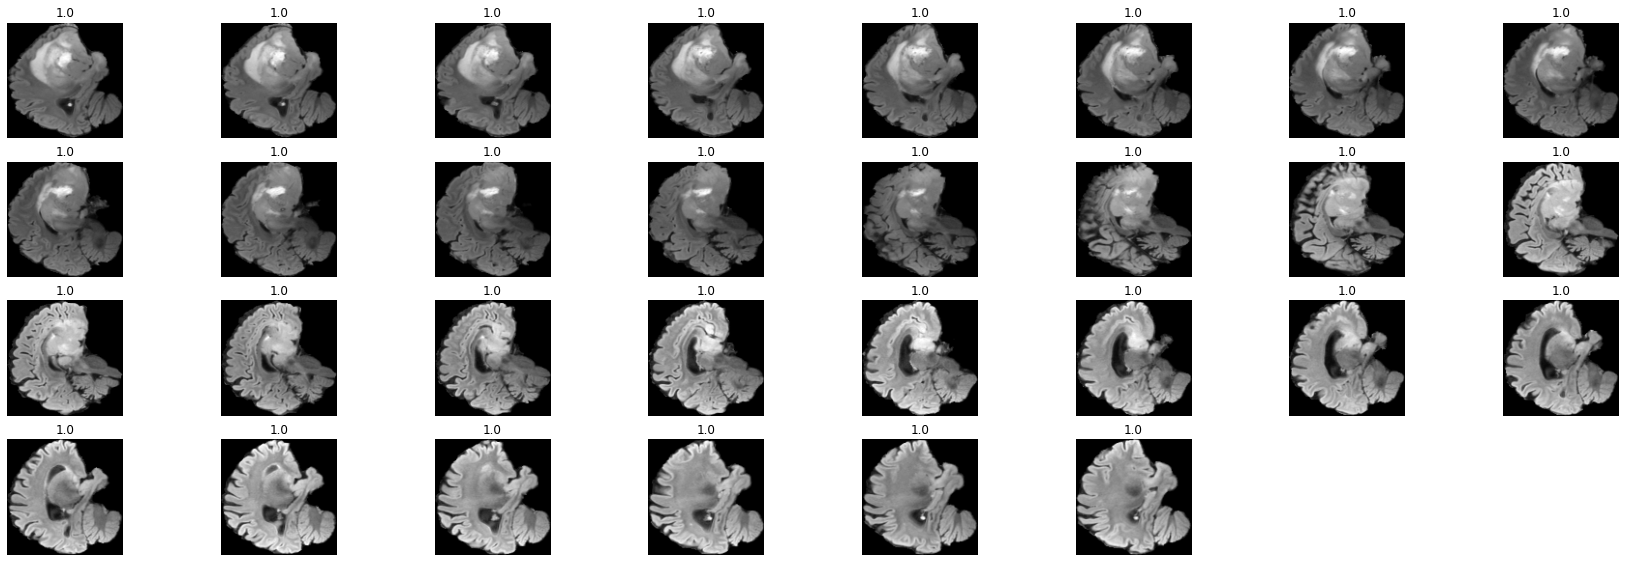

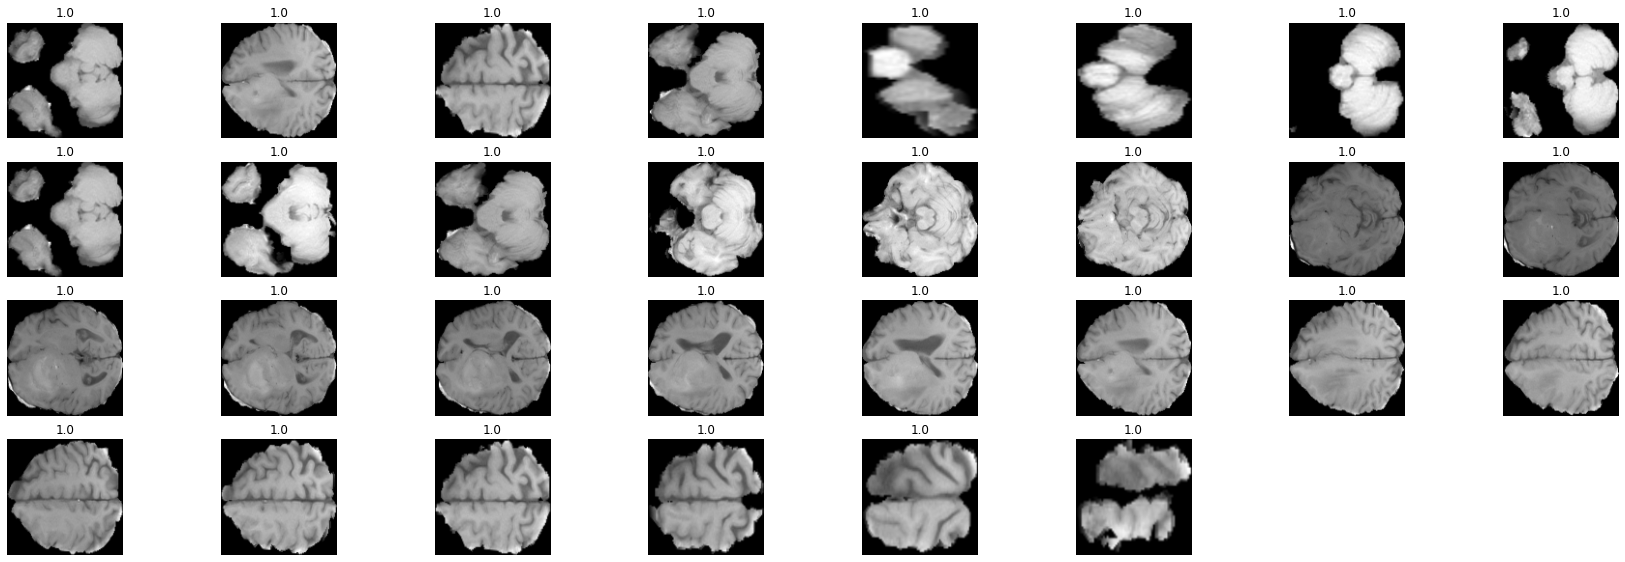

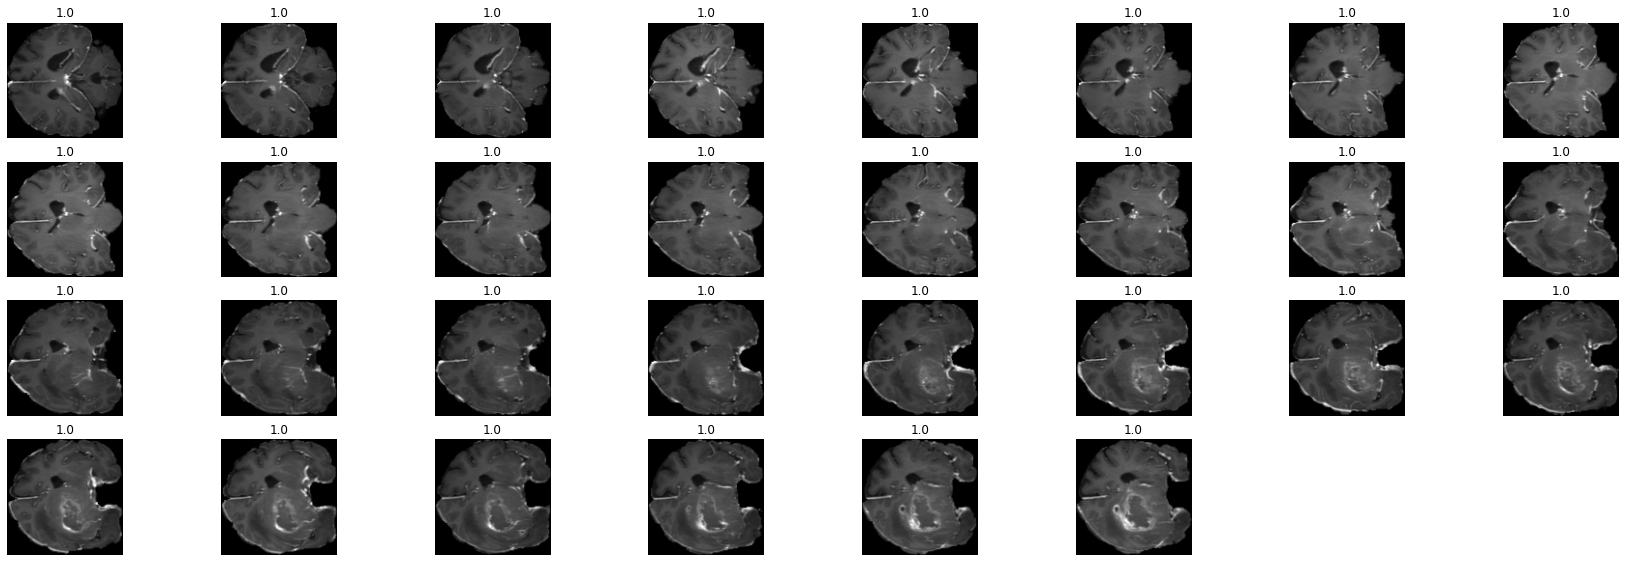

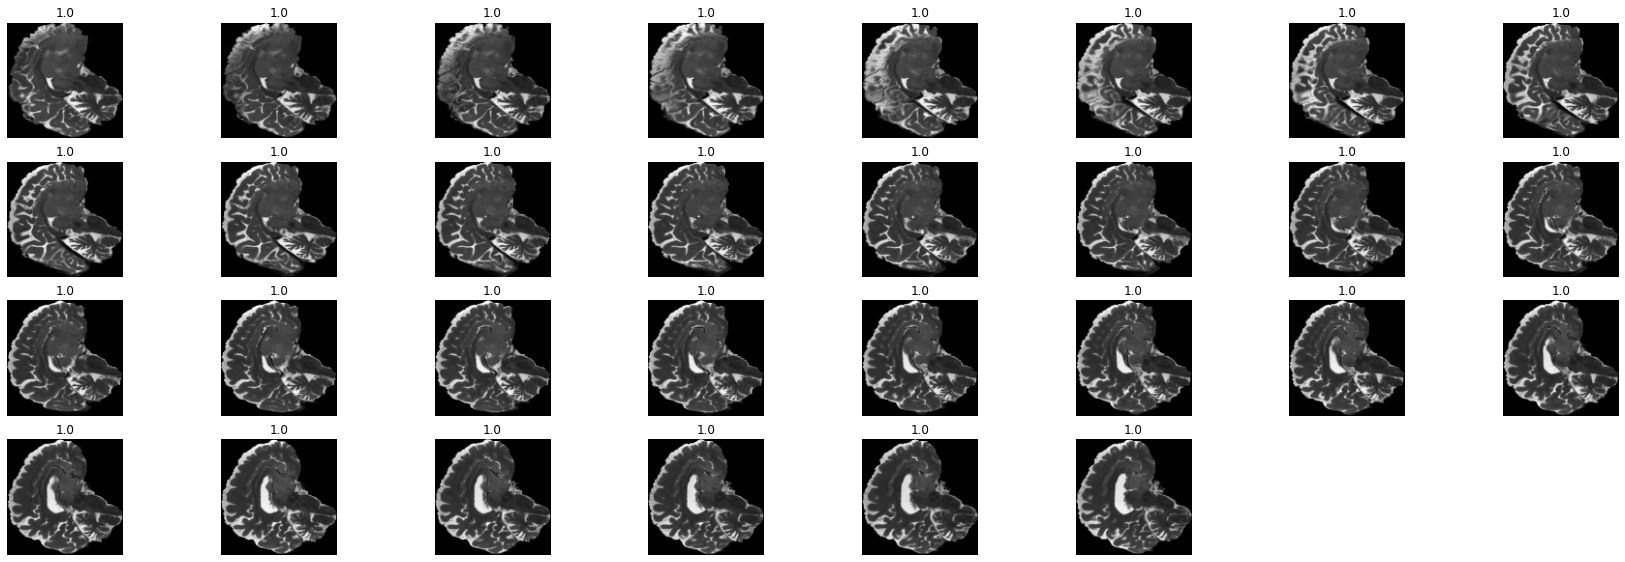

In [22]:
x, y = next(iter(valid_generator))
print(x.shape, y.shape, x.numpy().max(), y.numpy().min()) 

if modeling_in == '3D':
    for j in range(input_channel):
        plt.figure(figsize=(30, 20))
        for i in range(input_depth):
            plt.subplot(8, 8, i + 1)
            plt.imshow(x[0 ,:, :, i, j], cmap='gray')
            plt.axis("off")
            plt.title(y[0].numpy())
        plt.show()
elif modeling_in == '2D':
    plt.figure(figsize=(30, 20))
    for i in range(input_depth*input_channel):
        plt.subplot(5, 8, i + 1)
        plt.imshow(x[0 ,:, :, i], cmap='gray')
        plt.axis("off")
        plt.title(y[0].numpy())

# A. Modeling: 2D (Pre-trained Weights)

**UPDATE**: After version 8, 2D modeling is not supported. Please, check version 8 or older if needed.

---

# B. 3D Model : Pre-trained Weights

The pre-trained weights of `3D` model is taken from [ZFTurbo/efficientnet_3D](https://github.com/ZFTurbo/efficientnet_3D) and [ZFTurbo/classification_models_3D](https://github.com/ZFTurbo/classification_models_3D). The weight files are uploaded and can be found from here ([efnet-3d](https://www.kaggle.com/ipythonx/keras-3d-efficientnet-imagenet-weights-b0b7)) and here ([classification-3d](https://www.kaggle.com/ipythonx/pretrained-3d-model-weights-keras)) respectively. It contains 

```
EfficientNet B0 - B7 
ResNet [18, 34, 50, 101, 152]
ResNeXt [50, 101]
SE-ResNet [18, 34, 50, 101, 152]
SE-ResNeXt [50, 101]
SE-Net [154]
DenseNet [121, 169, 201]
MobileNet
MobileNet v2
````

## `TF.Keras` Model Subclassing: BrainTumorModel3D

In **3D model** training, we need to use lower batch size for expensive computation cost which is somewhat not wanted. So, we will be trying to use **Gradient Accumulation (GA)** technique to over come this issue. In `TF.Keras`, we can customize the popular `.fit` method easily to implement such various techniques and able to control every training details. If you're new to `keras` model subclassing and custom scratch training, you're welcome to check this [medium documents](https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e). 

**Acknowledgement**: I was trying to implement **GA** by customizing the `fit` method but faced few issue and this guy, named [Mr.For Example](https://stackoverflow.com/a/66524901/9215780) on StackOverflow helped me to achieve this. Kudos to him.

In [23]:
class BrainTumorModel3D(keras.Model):
    def __init__(self, 
                 model,           # Sequential or Functional or Subclass Model 
                 n_gradients=1,   # e.g total_batch_size = batch_size * n_gradients
                 *args, **kwargs):
        super(BrainTumorModel3D, self).__init__(*args, **kwargs)
        self.model = model
        self.n_gradients = tf.constant(n_gradients, dtype=tf.int32)
        self.n_acum_step = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.gradient_accumulation = [tf.Variable(tf.zeros_like(v, dtype=tf.float32), 
                                                  trainable=False) 
                                      for v in self.model.trainable_variables]

    # The training step, forward and backward propagation 
    def train_step(self, data):
        # Adding 1 to num_acum_step till n_gradients and start GA
        self.n_acum_step.assign_add(1)
        # Unpack the data 
        images, labels = data

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer or model .
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            predictions = self.model(images, training=True)
            # Compute the loss value for this minibatch.
            loss = self.compiled_loss(labels, predictions)
        
        # Compute batch gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Accumulating the batch gradients
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign_add(gradients[i])
 
        # If n_acum_step reach the n_gradients then we apply accumulated gradients -
        # - to update the variables otherwise do nothing
        tf.cond(tf.equal(self.n_acum_step, self.n_gradients),
                self.apply_accu_gradients, lambda: None)

        # update metrics
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}
    
    # Function for applying Gradient Accum. 
    def apply_accu_gradients(self):
        # Apply accumulated gradients
        self.optimizer.apply_gradients(zip(self.gradient_accumulation, 
                                           self.model.trainable_variables))

        # Reset
        self.n_acum_step.assign(0)
        for i in range(len(self.gradient_accumulation)):
            self.gradient_accumulation[i].assign(
                tf.zeros_like(self.model.trainable_variables[i],  dtype=tf.float32)
            )

    # The test step for evaluation and inference 
    def test_step(self, data):
        # Unpack the data 
        images, labels = data
        
        # Run model on inference mode 
        predictions = self.model(images, training=False)
        
        # Compute the loss value for this minibatch.
        loss = self.compiled_loss(labels, predictions)
        
        # Update metrics
        self.compiled_metrics.update_state(labels,  predictions)
        return {m.name: m.result() for m in self.metrics}
    
    # A call funciton needs to be implemented 
    def call(self, inputs, *args, **kwargs):
        return self.model(inputs)
    
    # A custom l2 regularization loss for model to tackle overfit 
    def reg_l2_loss(self, weight_decay = 1e-5):
        return weight_decay * tf.add_n([
            tf.nn.l2_loss(v)
            for v in self.model.trainable_variables
        ])

Let first define the **3D** model with well-know **Functional API** and after that we will pass it to the **Subclass API** model. Note, you can pass any model, whether it's **2D** or any custom model, plug-n-play now.

In [24]:
import efficientnet_3D.tfkeras as efn 
from classification_models_3D.tfkeras import Classifiers  

# build models 
input_tensor = keras.Input((input_height, input_width, 
                            input_depth, input_channel), name='input3D')
mapping3feat = keras.layers.Conv3D(3, (3,3,3), 
                                   strides=(1, 1, 1), 
                                   padding='same', 
                                   use_bias=True)(input_tensor)

mobilenetv2, _ = Classifiers.get('mobilenetv2')
feat_ext = mobilenetv2(input_shape=(input_height, input_width,input_depth, 3), 
                       include_top=False, weights='imagenet')

output = feat_ext(mapping3feat)
output = keras.layers.GlobalAveragePooling3D(keepdims=False)(output)
output = keras.layers.Dense(1, activation='sigmoid')(output)
model  = keras.Model(input_tensor, output)
model.summary()

10027008/10015920 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input3D (InputLayer)         [(None, 120, 120, 30, 4)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 120, 120, 30, 3)   327       
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1, 1280)     2388160   
_________________________________________________________________
global_average_pooling3d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,389,768
Trainable params: 2,355,656
Non-trainable params: 34,112
_________________________________________________________________


**Compiling the Model**

In [25]:
# Passing Functional Model on Subclass API class. 
# In order to get some leverage, i.e. Gradient Accumulation. 
keras.backend.clear_session()
model3D = BrainTumorModel3D(model, n_gradients = batch_size*accum_step)

# compiling 
model3D.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.SUM),
    optimizer=keras.optimizers.Ftrl(),
    metrics=[keras.metrics.AUC(), keras.metrics.BinaryAccuracy(name='acc')],
)

## Custom Callback

We will write a custom callback in `keras` to save the model weights based on some target metrics. 

In [26]:
# Define callbacks.
class CustomModelCheckpoint(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.val_loss = []
        self.val_auc  = []
        self.val_acc  = []
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get("val_loss")
        current_val_auc  = logs.get('val_auc')
        current_val_acc  = logs.get('val_acc')
        self.val_loss.append(current_val_loss)
        self.val_auc.append(current_val_auc)
        self.val_acc.append(current_val_acc)
        
        # save based on lowest validation loss 
        if current_val_loss <= min(self.val_loss):
            print('Find lowest val_loss. Saving model weight.')
            self.model.save_weights('model_at_val_loss.h5') 
            
        # save based on highest validation auc 
        if current_val_auc >= max(self.val_auc):
            print('Find highest val_auc. Saving model weight.')
            self.model.save_weights('model_at_val_auc.h5') 
        
        # save based on highest validation acc
        if current_val_acc >= max(self.val_acc):
            print('Find highest val_acc. Saving model weight.')
            self.model.save_weights('model_at_val_acc.h5') 

# A custom lr sched 
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [27]:
# epoch params
epochs = 5

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset
model3D.fit(
    train_generator.take(100),
    epochs=epochs,
    validation_data=valid_generator.take(50),
    callbacks=[CustomModelCheckpoint(), 
               tf.keras.callbacks.CSVLogger('history.csv'),
               get_lr_callback(batch_size)], 
    verbose=1
)

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 5e-06.
100/100 [==============================] - 1012s 5s/step - loss: 0.0860 - auc: 0.4914 - acc: 0.4900 - val_loss: 0.0884 - val_auc: 0.5000 - val_acc: 0.5200
Find lowest val_loss. Saving model weight.
Find highest val_auc. Saving model weight.
Find highest val_acc. Saving model weight.
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 4.25e-06.
100/100 [==============================] - 376s 4s/step - loss: 0.0840 - auc: 0.5000 - acc: 0.4700 - val_loss: 0.0884 - val_auc: 0.5000 - val_acc: 0.5200
Find lowest val_loss. Saving model weight.
Find highest val_auc. Saving model weight.
Find highest val_acc. Saving model weight.
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 3.5000000000000004e-06.
100/100 [==============================] - 375s 4s/step - loss: 0.0840 - auc: 0.5000 - acc: 0.4700 - val_loss: 0.0884 - val_auc: 0.5000 - val_acc: 0.5200
Find lowest val_loss. Sav

# Final Note

- I've made public repository to store and mange the above codes. You can find it [here](https://github.com/innat/BraTS-MGMT-Classification). I'll try to improve it when time permists and of course PRs or Suggestions are warmly welcomed. Some possible todo list are as follows
    - Optimize Input Pipeline 
    - Add TPU and TFRecord Support 
    - Add 3D-Grad-CAM 
    - Integrate Semantic Segmentation Modeling (task 1, [read more](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/253488))
- Following notebooks are worth reading. It provides some great insight. 
    - [Connecting voxel spaces](https://www.kaggle.com/boojum/connecting-voxel-spaces)
    - [Manual VOI LUT on MR Images](https://www.kaggle.com/davidbroberts/manual-voi-lut-on-mr-images)
    - [Determining MR Image Planes](https://www.kaggle.com/davidbroberts/determining-mr-image-planes)
    - [Normalized Voxels: Align Planes and Crop](https://www.kaggle.com/ren4yu/normalized-voxels-align-planes-and-crop)
    - [Brain Tumor - EDA with Animations and Modeling](https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling)
    - [RSNA-MICCAI BTRC: Understanding The Data](https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data)
    - [[Train] Brain Tumor as Video Classification + W&B](https://www.kaggle.com/ayuraj/train-brain-tumor-as-video-classification-w-b)
    - [RSNA Brain Tumor-Tensorflow TPU TFRecords Train](https://www.kaggle.com/kavehshahhosseini/rsna-brain-tumor-tensorflow-tpu-tfrecords-train)
- After training with **k-fold**, if you begin to start ensembling, then this may help: [Optimizing Metrics: Out-of-Fold Weights Ensemble](https://www.kaggle.com/ipythonx/optimizing-metrics-out-of-fold-weights-ensemble/notebook)
    - Scipy Optimization (**L-BFGS-B**)
    - Bayesian Optimization
---

> - **[WIP]**: Training : ✔
> - **[WIP]**: Inference : ✔ [Check.](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/280107)

# Miscellaneous 

Rest of the cell currently on the **Void** zone. These were being used at the early of this competition. But I didn't remove them in case if it helps others.

---

# C. Modeling (InceptionResNet-3D) : No Pre-trained Weights

We couldn't find any well recognized 3D pretrained weights yet, so here we will build a shallow 3D network. 

---

**Version 8 Update**: We won't train `InceptionResNet3D` now, as we have pre-trained 3D models to work with.

In [28]:
import tensorflow as tf 
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

class Conv3DBatchNorm(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size, padding, strides):
        super(Conv3DBatchNorm, self).__init__()
        '''ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # parameters 
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size 
        self.padding = padding 
        self.strides = strides 

        # layers
        self.conv = tf.keras.layers.Conv3D(self.nb_filters, self.kernel_size, 
                                           self.strides, self.padding)
        self.bn   = tf.keras.layers.BatchNormalization()
        
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        return tf.nn.relu(x)
    
    def get_config(self):
        return {
            'nb_filters': self.nb_filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'strides': self.strides
        }

In [29]:
class Inception3DModule(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size1x1, kernel_size3x3):
        super(Inception3DModule, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # params 
        self.nb_filters = nb_filters
        self.kernel_size1x1 = kernel_size1x1
        self.kernel_size3x3 = kernel_size3x3

        # layers 
        self.conv1 = Conv3DBatchNorm(self.nb_filters, 
                                     kernel_size=self.kernel_size1x1,
                                     strides=1, padding='same')
        self.conv2 = Conv3DBatchNorm(self.nb_filters, 
                                     kernel_size=self.kernel_size3x3, 
                                     strides=1, padding='same')
        self.cat   = tf.keras.layers.Concatenate()

    def call(self, input_tensor, training=False):
        x_1x1 = self.conv1(input_tensor)
        x_3x3 = self.conv2(input_tensor)
        x = self.cat([x_1x1, x_3x3])
        return tf.nn.relu(x) 

    def get_config(self):
        return {
            'nb_filters': self.nb_filters,
            'kernel_size1x1': self.kernel_size1x1,
            'kernel_size3x3': self.kernel_size3x3
        }

In [30]:
class Identity3DBlock(tf.keras.layers.Layer):
    def __init__(self, nb_filters, kernel_size, padding, strides, shortcut = False):
        super(Identity3DBlock, self).__init__()
        '''
        ref: https://gist.github.com/innat/1bc1307044a10a66a63eae9a71294117
        '''
        # params 
        self.shortcut = shortcut 
        self.nb_filters = nb_filters 
        self.kernel_size = kernel_size 
        self.padding = padding 
        self.strides = strides 
        
        # layers 
        self.conv1 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.conv2 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.conv3 = Conv3DBatchNorm(self.nb_filters, self.kernel_size, 
                                     self.padding, self.strides)
        self.inception = Inception3DModule(self.nb_filters, 
                                           kernel_size1x1 = (1,1,1),
                                           kernel_size3x3 = (3,3,3))
    
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.shortcut:
            srtct = self.inception(input_tensor)
            srtct = self.conv3(srtct)
            x = Dropout(0.3)(x)
            x = Add()([x, srtct])
            return tf.nn.relu(x)
        else:
            x = Add()([x, input_tensor])
            return tf.nn.relu(x)
        
    def get_config(self):
        return {
            'shortcut': self.shortcut,
            'nb_filters': self.nb_filters,
            'kernel_size': self.kernel_size,
            'padding': self.padding,
            'strides': self.strides,
        }

In [31]:
def InceptionResNet3D(width=128, height=128, depth=32, num_cls=1):
    inpt = Input((width, height, depth, 1), name='input3D')
    x = ZeroPadding3D((1, 1, 1))(inpt)

    # conv3d + relu + maxplo3d 
    x = Conv3DBatchNorm(nb_filters=16, kernel_size=(3, 3, 3), 
                        strides=1, padding='valid')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=1)(x)

    # inception_resnet_block_ab
    x = Identity3DBlock(nb_filters=32, kernel_size=(3, 3, 3), 
                        padding='same', strides=1, shortcut=True)(x)
    x = Identity3DBlock(nb_filters=32, kernel_size=(3, 3, 3), 
                        padding='same', strides=1)(x)

    x = AveragePooling3D(pool_size=(2, 2, 2))(x)
    x = GlobalAveragePooling3D()(tf.nn.relu(x))
    x = Dense(num_cls, activation='sigmoid')(x)

    model = Model(inputs=inpt, outputs=x)
    return model

In [32]:
tf.keras.backend.clear_session()
model = InceptionResNet3D(width=input_width, height=input_height, 
                          depth=input_depth, num_cls=1)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input3D (InputLayer)         [(None, 120, 120, 30, 1)] 0         
_________________________________________________________________
zero_padding3d (ZeroPadding3 (None, 122, 122, 32, 1)   0         
_________________________________________________________________
conv3d_batch_norm (Conv3DBat (None, 120, 120, 30, 16)  512       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 119, 119, 29, 16)  0         
_________________________________________________________________
identity3d_block (Identity3D (None, 119, 119, 29, 32)  111904    
_________________________________________________________________
identity3d_block_1 (Identity (None, 119, 119, 29, 32)  55616     
_________________________________________________________________
average_pooling3d (AveragePo (None, 59, 59, 14, 32)    0     